# Quick start

Welcome to the quick start guide for running the open-source AlphaGenome model.

The goal of this tutorial is to quickly get you up to speed with running the
model and making some predictions.

We **strongly** recommend you use our hosted
[AlphaGenome model](https://deepmind.google.com/science/alphagenome), unless you
need to do something which isn't supported (e.g. fine-tuning, running offline or
large scale inference). This is because it doesn't require any specialist
hardware, so is quicker and easier to use.

## Prerequisites

-   Familiarity with the [AlphaGenome API](https://www.alphagenomedocs.com/).
    See the API
    [quick start guide](https://colab.research.google.com/github/google-deepmind/alphagenome/blob/main/colabs/quick_start.ipynb)
    to get started.
-   Machine with H100 NVIDIA GPU, equivalent TPU or newer. You will need to have
    installed JAX with the correct drivers for your system, please follow
    [this guide](https://docs.jax.dev/en/latest/installation.html) on how to do
    this. For this tutorial, the easiest option is to use
    [Colab Pro](https://colab.research.google.com/signup).

In [1]:
# @title Install the AlphaGenome model source code.

# @markdown Run this cell to install the AlphaGenome model code.
from IPython.display import clear_output
! pip install git+https://github.com/google-deepmind/alphagenome_research.git
clear_output()

## **Imports**

In [2]:
import os

from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.visualization import plot_components
from alphagenome_research.model import dna_model
import matplotlib
import numpy as np
import pandas as pd

### Optional: XLA flags for determinism

These aren't strictly necessary, but it helps improve the model's deterministic
outputs by disabling certain XLA optimizations that are stochastic. See the
[XLA determinism](https://openxla.org/xla/determinism) documentation for more
details.

These flags must be run before executing any model code.

In [3]:
# Flags to improve determinism.
os.environ['XLA_FLAGS'] = ' '.join([
    '--xla_gpu_deterministic_ops',
    '--xla_gpu_enable_scatter_determinism_expander=True',
    '--xla_gpu_enable_triton_gemm=False',
])
# Increase GPU and CPU memory to reduce out of memory errors.
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.9'

## Loading the DNA Model

For this tutorial, we will load the model such that we can interact with it in
the same way as the hosted
[AlphaGenome API](https://deepmind.google.com/science/alphagenome). This wraps
the core model and provides a more intuitive set of functions for creating
predictions, scoring variants, performing in-silico-mutagenesis (ISM) and more.

It also lets us use the plotting code to easily visualize predictions.

First, we need to download the pre-trained weights, which can be obtained from
either [Kaggle](https://www.kaggle.com/models/google/alphagenome) or
[Hugging Face](https://huggingface.co/collections/google/alphagenome).

The easiest way to do this is to use the following helper functions:

-   `dna_model.create_from_kaggle('all_folds')` for Kaggle, or
-   `dna_model.create_from_huggingface('all_folds')` for Hugging Face.

These functions will authenticate, download the weights and configure the DNA
model wrapper appropriately.

In [4]:
model = dna_model.create_from_kaggle('all_folds')
clear_output()

You should now have a model instance that you can interact with.

For example, we can see how many human tracks the model has been trained on by
running the following:

In [5]:
print('Number of human tracks per output type\n')
metadata = model.output_metadata(dna_model.Organism.HOMO_SAPIENS)

total = 0
for output_type in dna_model.OutputType:
  num_tracks = len(metadata.get(output_type))
  # Splice junctions are strand agnostic, so return 2 * num_tracks.
  if output_type == dna_model.OutputType.SPLICE_JUNCTIONS:
    num_tracks *= 2
  total += num_tracks
  print(f'{output_type.name:<20} {num_tracks}')
print(f'\n{"Total:":<20} {total}')

Number of human tracks per output type

ATAC                 167
CAGE                 546
DNASE                305
RNA_SEQ              667
CHIP_HISTONE         1116
CHIP_TF              1617
SPLICE_SITES         4
SPLICE_SITE_USAGE    734
SPLICE_JUNCTIONS     734
CONTACT_MAPS         28
PROCAP               12

Total:               5930


## Reproducing paper figures

For the rest of this tutorial, we will reproduce several figures from the
AlphaGenome manuscript using the open-source model and visualization library to
plot the results.

We first load up a GTF file containing gene and transcript locations as
annotated by GENCODE (more information on GTF format
[here](https://www.gencodegenes.org/pages/data_format.html)):

In [6]:
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Set up transcript extractors using the information in the GTF file.
# MANE Select defines one curated transcript per gene.
gtf_transcripts = gene_annotation.filter_protein_coding(gtf)
gtf_transcripts = gene_annotation.filter_to_mane_select_transcript(
    gtf_transcripts
)
transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcripts)

### Figure 2a

This figure presents several AlphaGenome track predictions within a 1 Mb region
of human chromosome 19 (0-based coordinates: 10587331-11635907) in the HepG2
cell line.

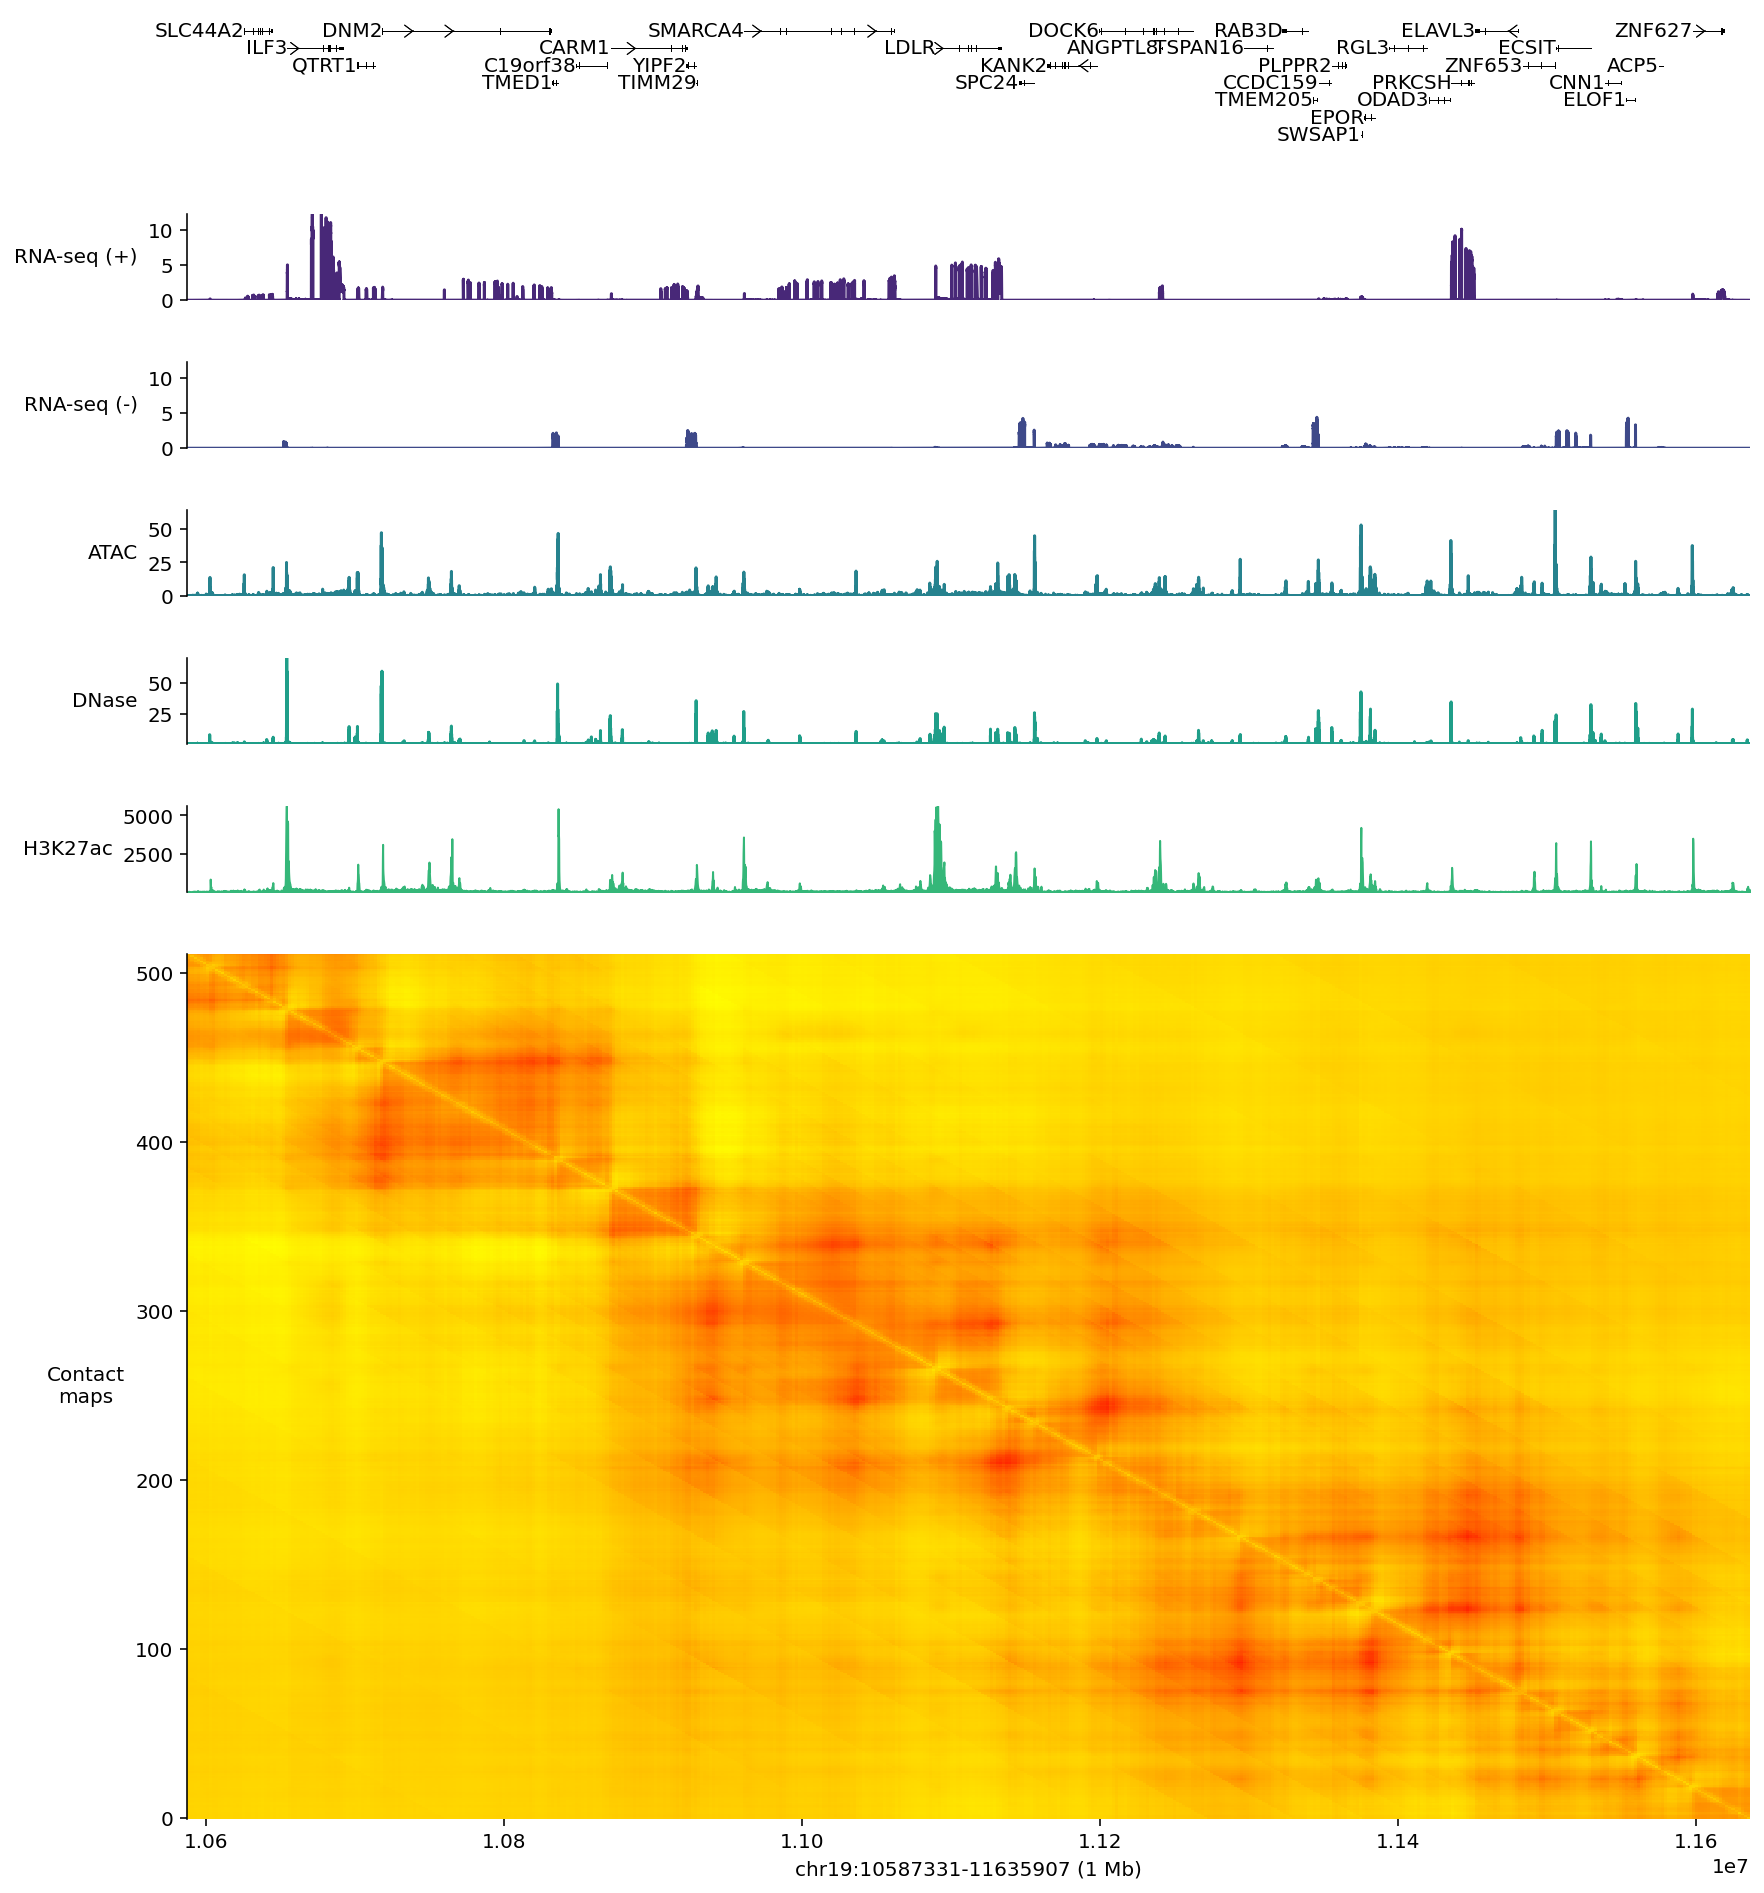

In [7]:
def _get_colors_hex(cmap_name, n):
  cmap = matplotlib.colormaps[cmap_name]
  return [matplotlib.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, n)][1:]


interval = genome.Interval('chr19', 1_058_7331, 1_163_5907, strand='+')
predictions = model.predict_interval(
    interval,
    requested_outputs={
        dna_model.OutputType.RNA_SEQ,
        dna_model.OutputType.DNASE,
        dna_model.OutputType.ATAC,
        dna_model.OutputType.CHIP_TF,
        dna_model.OutputType.CHIP_HISTONE,
        dna_model.OutputType.CONTACT_MAPS,
    },
    ontology_terms=['EFO:0001187'],
)
colors_hex = _get_colors_hex('viridis', 10)

output_rna_seq = predictions.rna_seq.filter_tracks(
    (predictions.rna_seq.metadata['Assay title'] == 'total RNA-seq').values
)

output_chip_histone = predictions.chip_histone.filter_tracks(
    (predictions.chip_histone.metadata['histone_mark'] == 'H3K27ac').values
)

output_chip_tf = predictions.chip_tf.filter_tracks(
    (
        (predictions.chip_tf.metadata['transcription_factor'] == 'CTCF')
        & (predictions.chip_tf.metadata['genetically_modified'].isnull())
    ).values
)

_ = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(
            transcript_extractor.extract(interval)
        ),
        plot_components.Tracks(
            output_rna_seq,
            ylabel_template='RNA-seq ({strand})',
            track_colors=colors_hex[0:2],
            shared_y_scale=True,
        ),
        plot_components.Tracks(
            predictions.atac,
            ylabel_template='ATAC',
            track_colors=colors_hex[3],
            shared_y_scale=True,
        ),
        plot_components.Tracks(
            predictions.dnase,
            ylabel_template='DNase',
            track_colors=colors_hex[4],
            shared_y_scale=True,
        ),
        plot_components.Tracks(
            output_chip_histone,
            ylabel_template='H3K27ac',
            filled=True,
            track_colors=colors_hex[5],
            shared_y_scale=True,
        ),
        plot_components.Tracks(
            output_chip_tf,
            ylabel_template='CTCF',
            filled=True,
            track_colors=colors_hex[6],
            shared_y_scale=True,
        ),
        plot_components.ContactMaps(
            predictions.contact_maps,
            ylabel_template='Contact\nmaps',
        ),
    ],
    interval=interval,
    fig_width=14,
    xlabel='{}:{}-{} (1 Mb)'.format(
        interval.chromosome, interval.start, interval.end
    ),
)

### Figure 3c

This figure shows an example of a variant causing alternative splice junction
formation in the *COL6A2* gene by creating a new splicing donor and disrupting
the extant one. Predicted tracks are from the Aorta tissue.

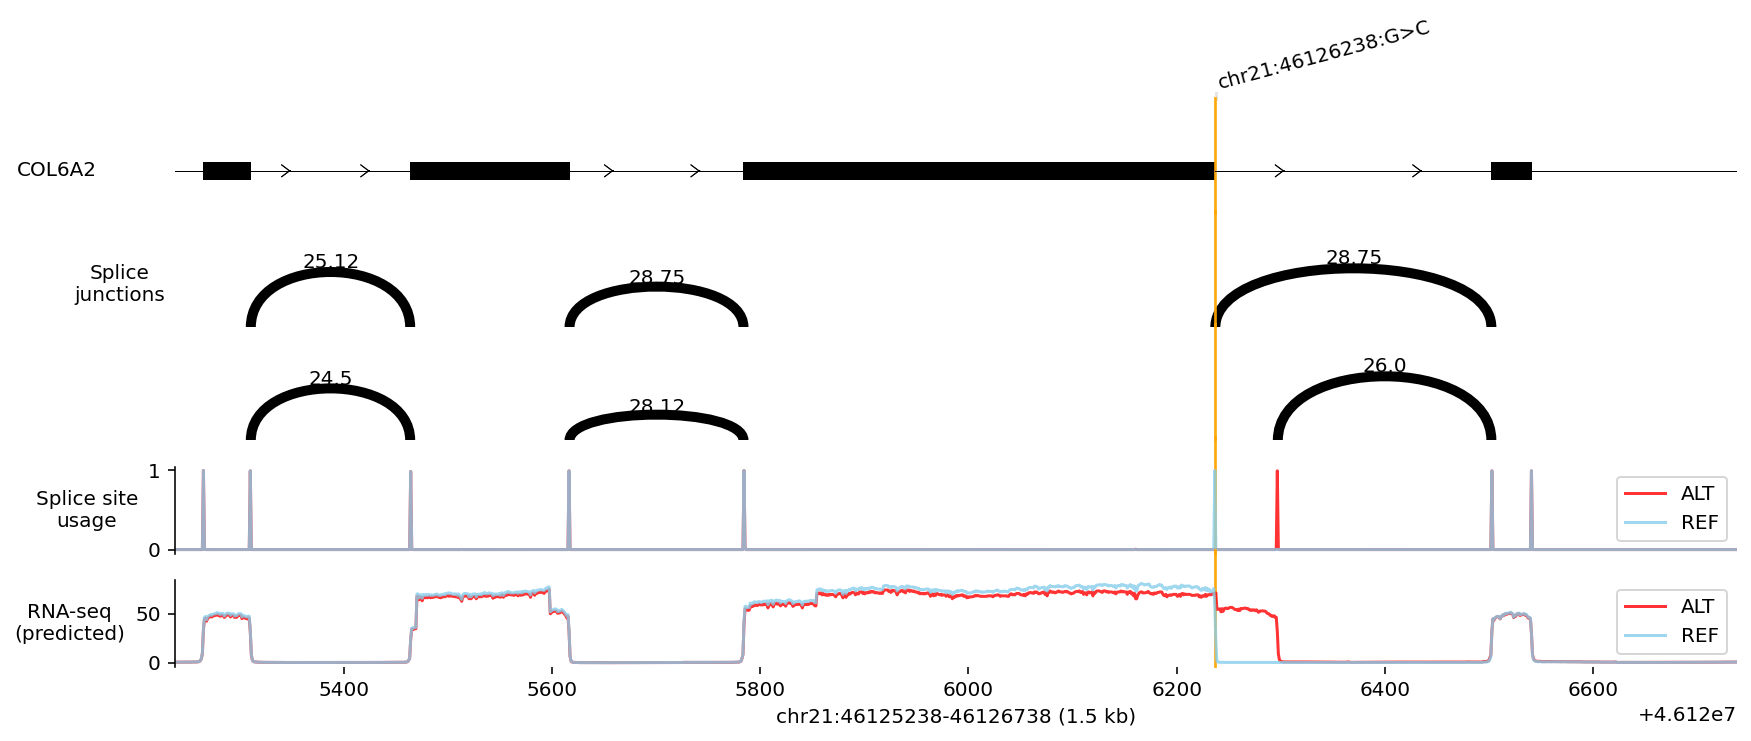

In [8]:
variant = genome.Variant.from_str('chr21:46126238:G>C')
interval = variant.reference_interval.resize(2**20)

predictions = model.predict_variant(
    interval,
    variant,
    requested_outputs=[
        dna_model.OutputType.SPLICE_JUNCTIONS,
        dna_model.OutputType.SPLICE_SITE_USAGE,
        dna_model.OutputType.RNA_SEQ,
    ],
    ontology_terms=['UBERON:0001496'],
)

ref_alt_colors = {'REF': 'skyblue', 'ALT': 'red'}
plot_interval = genome.Interval.from_str('chr21:46125238-46126738')
rng = np.random.default_rng(seed=42)

ref_splice_sites = predictions.reference.splice_site_usage
ref_splice_sites = ref_splice_sites.filter_tracks(
    (ref_splice_sites.metadata['Assay title'] == 'polyA plus RNA-seq').values
)

alt_splice_sites = predictions.alternate.splice_site_usage
alt_splice_sites = alt_splice_sites.filter_tracks(
    (alt_splice_sites.metadata['Assay title'] == 'polyA plus RNA-seq').values
)

_ = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(
            transcript_extractor.extract(interval)
        ),
        plot_components.Sashimi(
            predictions.reference.splice_junctions.filter_by_tissue(  # pytype: disable=attribute-error
                'Artery_Aorta'
            ).filter_to_strand(  # pytype: disable=attribute-error
                '+'
            ),
            ylabel_template='Splice\njunctions',
            normalize_values=False,
            rng=rng,
        ),
        plot_components.Sashimi(
            predictions.alternate.splice_junctions.filter_by_tissue(  # pytype: disable=attribute-error
                'Artery_Aorta'
            ).filter_to_strand(  # pytype: disable=attribute-error
                '+'
            ),
            ylabel_template='',
            normalize_values=False,
            rng=rng,
        ),
        plot_components.OverlaidTracks(
            tdata={
                'REF': ref_splice_sites.filter_to_positive_strand(),
                'ALT': alt_splice_sites.filter_to_positive_strand(),
            },
            colors=ref_alt_colors,
            ylabel_template='Splice site\nusage',
        ),
        plot_components.OverlaidTracks(
            tdata={
                'REF': predictions.reference.rna_seq.filter_to_unstranded(),  # pytype: disable=attribute-error
                'ALT': predictions.alternate.rna_seq.filter_to_unstranded(),  # pytype: disable=attribute-error
            },
            colors=ref_alt_colors,
            ylabel_template='RNA-seq\n(predicted)',
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=plot_interval,
    fig_width=14,
    xlabel='{}:{}-{} (1.5 kb)'.format(
        plot_interval.chromosome, plot_interval.start, plot_interval.end
    ),
)

### Figure 4b

Example predictions for a known eQTL (chr22:36201698:A>C) with SuSiE PIP > 0.9
in GTEx Colon (Sigmoid) tissue.

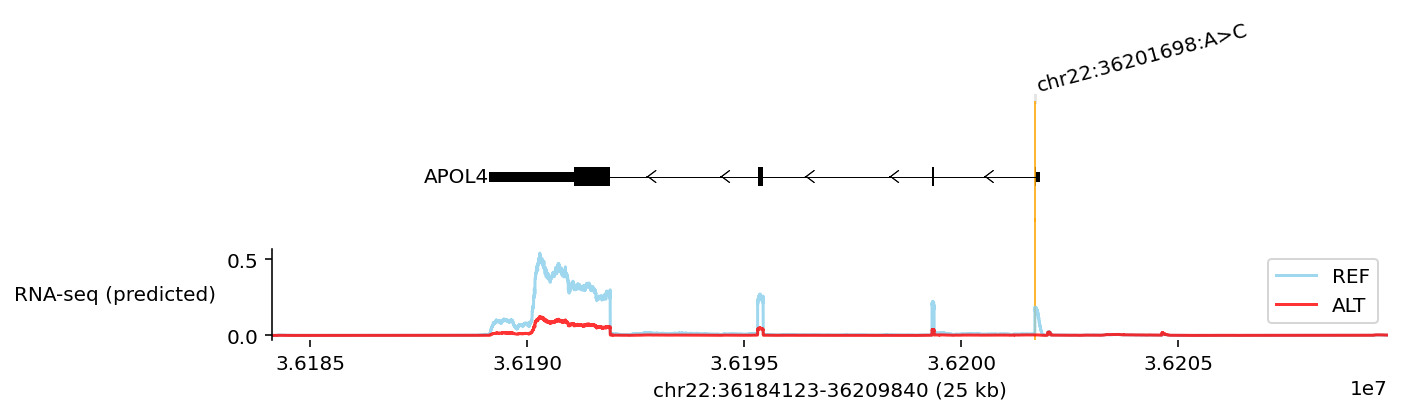

In [9]:
variant = genome.Variant.from_str('chr22:36201698:A>C')
interval = variant.reference_interval.resize(2**20)

predictions = model.predict_variant(
    interval,
    variant,
    requested_outputs=[dna_model.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0001159'],
)

ref_alt_colors = {'REF': 'skyblue', 'ALT': 'red'}
plot_interval = genome.Interval.from_str('chr22:36184123-36209840')

_ = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(
            transcript_extractor.extract(interval)
        ),
        plot_components.OverlaidTracks(
            tdata={
                'REF': predictions.reference.rna_seq.filter_to_unstranded(),
                'ALT': predictions.alternate.rna_seq.filter_to_unstranded(),
            },
            colors=ref_alt_colors,
            ylabel_template='RNA-seq (predicted)',
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=plot_interval,
    fig_width=10,
    xlabel='{}:{}-{} (25 kb)'.format(
        plot_interval.chromosome, plot_interval.start, plot_interval.end
    ),
)

### Figure 5e

Example AlphaGenome predictions for selected caQTLs. Shown are ALT-REF
differences in a predicted DNase track (GM12878).

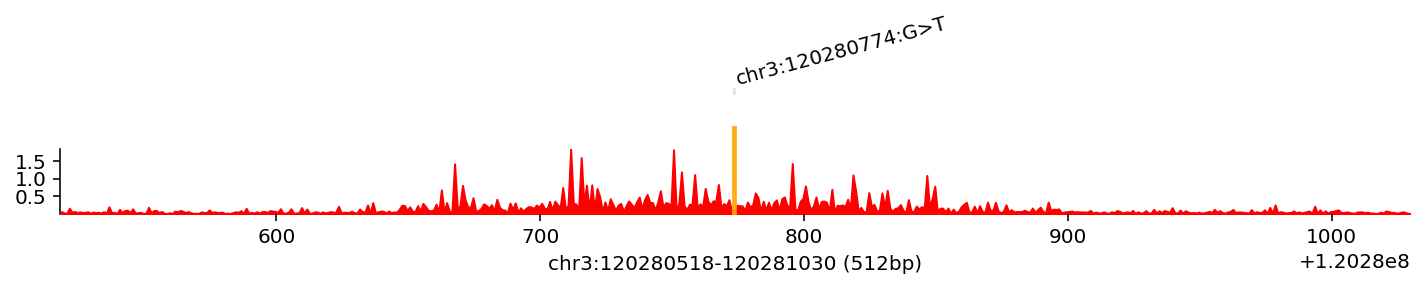

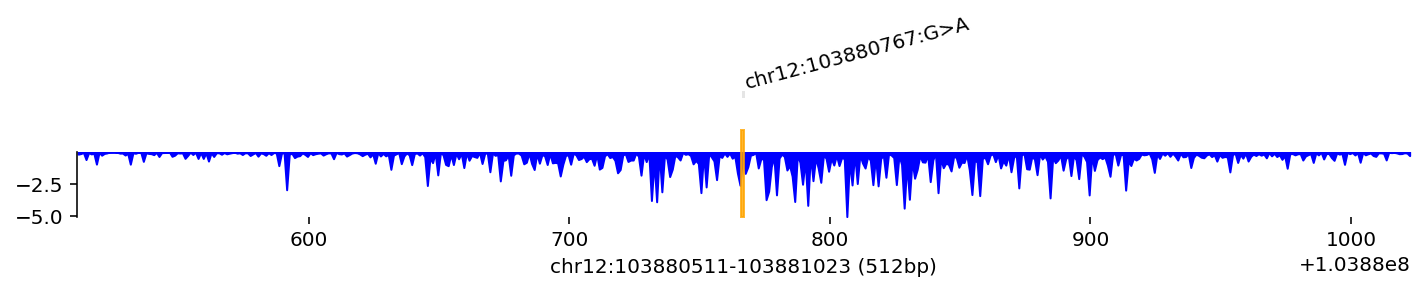

In [10]:
variant = genome.Variant.from_str('chr3:120280774:G>T')
interval = variant.reference_interval.resize(2**20)

predictions = model.predict_variant(
    interval,
    variant,
    requested_outputs=[dna_model.OutputType.DNASE],
    ontology_terms=['EFO:0002784'],
)

plot_interval = genome.Interval.from_str('chr3:120280518-120281030')

figure = plot_components.plot(
    [
        plot_components.Tracks(
            predictions.alternate.dnase - predictions.reference.dnase,
            ylabel_template='',
            track_colors='red',
            filled=True,
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=plot_interval,
    fig_width=10,
    xlabel='{}:{}-{} (512bp)'.format(
        plot_interval.chromosome, plot_interval.start, plot_interval.end
    ),
)
figure.tight_layout()

variant = genome.Variant.from_str('chr12:103880767:G>A')
interval = variant.reference_interval.resize(2**20)

predictions = model.predict_variant(
    interval,
    variant,
    requested_outputs=[dna_model.OutputType.DNASE],
    ontology_terms=['EFO:0002784'],
)

plot_interval = interval.resize(512)

figure = plot_components.plot(
    [
        plot_components.Tracks(
            predictions.alternate.dnase - predictions.reference.dnase,
            ylabel_template='',
            track_colors='blue',
            filled=True,
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=plot_interval,
    fig_width=10,
    xlabel='{}:{}-{} (512bp)'.format(
        plot_interval.chromosome, plot_interval.start, plot_interval.end
    ),
)
figure.tight_layout()

### Figure 6b

Detailed ALT-REF predictions for an oncogenic insertion (chr1:47239296:C>ACG)
characterized in Mansour *et al.* 2014.

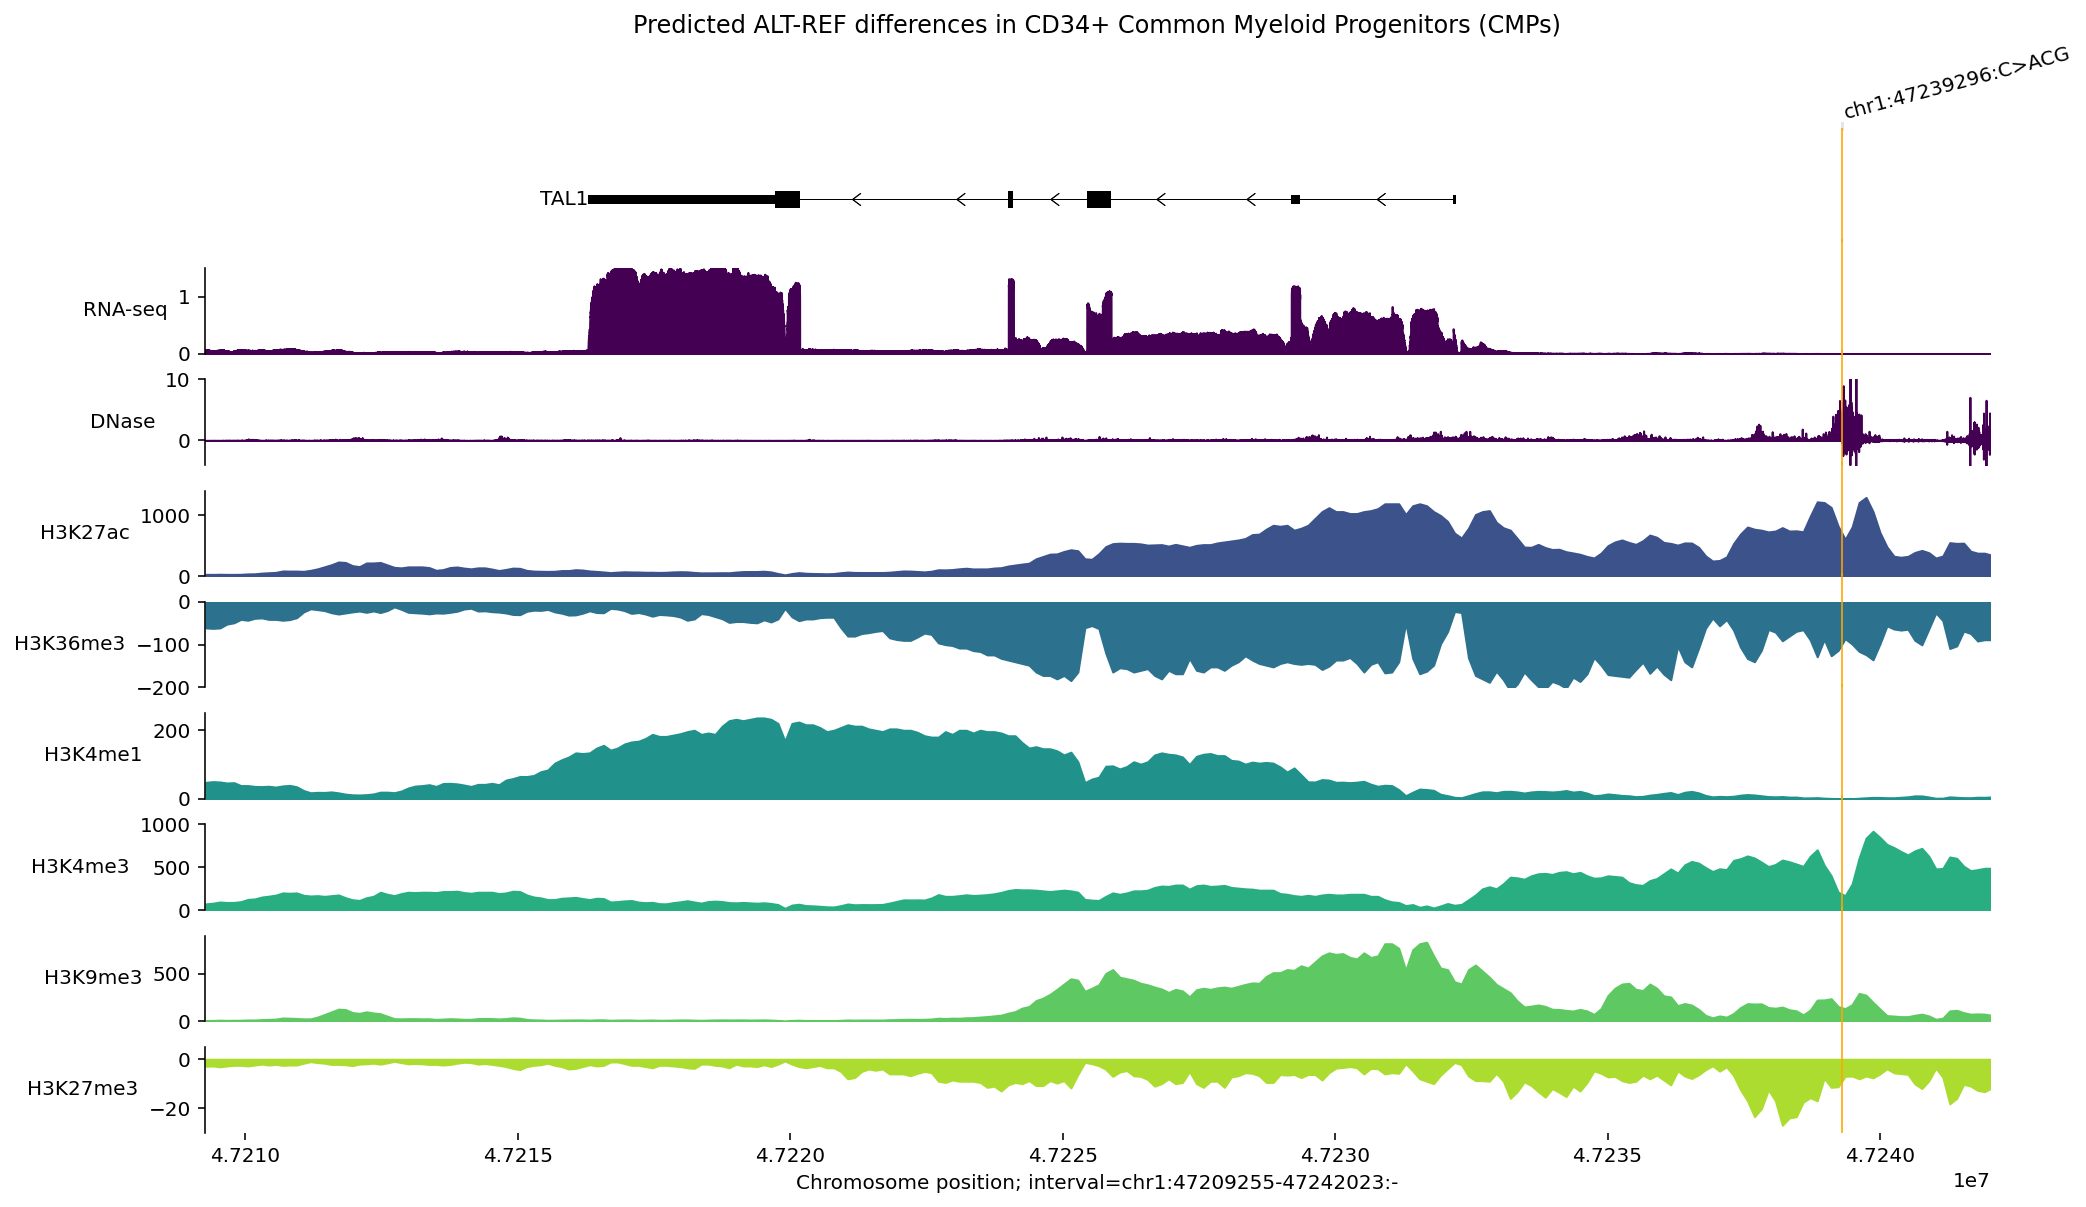

In [11]:
variant = genome.Variant.from_str('chr1:47239296:C>ACG')
interval = variant.reference_interval.resize(2**17)
prediction = model.predict_variant(
    interval,
    variant,
    ontology_terms=['CL:0001059'],
    requested_outputs={
        dna_model.OutputType.RNA_SEQ,
        dna_model.OutputType.CHIP_HISTONE,
        dna_model.OutputType.DNASE,
    },
)

tal1_interval = genome.Interval.from_str('chr1:47209255-47242023:-')

chip_alt_ref = (
    prediction.alternate.chip_histone.filter_to_nonpositive_strand()
    - prediction.reference.chip_histone.filter_to_nonpositive_strand()
)


def _get_colors_hex(cmap_name, n):
  cmap = matplotlib.colormaps[cmap_name]
  return [matplotlib.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, n)][1:]


colors_hex = _get_colors_hex('viridis', 9)

_ = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(
            transcript_extractor.extract(interval)
        ),
        # RNA-seq tracks.
        plot_components.Tracks(
            tdata=(
                prediction.alternate.rna_seq.filter_to_nonpositive_strand()
                - prediction.reference.rna_seq.filter_to_nonpositive_strand()
            ),
            ylabel_template='RNA-seq',
            shared_y_scale=True,
            filled=True,
            global_ylims=(0, 1.5),
        ),
        # DNase tracks.
        plot_components.Tracks(
            tdata=(
                prediction.alternate.dnase.filter_to_nonpositive_strand()
                - prediction.reference.dnase.filter_to_nonpositive_strand()
            ),
            ylabel_template='DNase',
            shared_y_scale=True,
            filled=True,
            global_ylims=(-4, 10),
        ),
        # ChIP histone.
        plot_components.Tracks(
            chip_alt_ref.filter_tracks(np.eye(1, 6, 0, dtype=bool)[0]),
            ylabel_template='H3K27ac',
            shared_y_scale=True,
            global_ylims=(0, 1400),
            filled=True,
            track_colors=colors_hex[1],
        ),
        plot_components.Tracks(
            chip_alt_ref.filter_tracks(np.eye(1, 6, 1, dtype=bool)[0]),
            ylabel_template='H3K36me3',
            shared_y_scale=True,
            filled=True,
            global_ylims=(-200, 0),
            track_colors=colors_hex[2],
        ),
        plot_components.Tracks(
            chip_alt_ref.filter_tracks(np.eye(1, 6, 2, dtype=bool)[0]),
            ylabel_template='H3K4me1',
            shared_y_scale=True,
            filled=True,
            global_ylims=(0, 250),
            track_colors=colors_hex[3],
        ),
        plot_components.Tracks(
            chip_alt_ref.filter_tracks(np.eye(1, 6, 3, dtype=bool)[0]),
            ylabel_template='H3K4me3',
            shared_y_scale=True,
            filled=True,
            global_ylims=(0, 1000),
            track_colors=colors_hex[4],
        ),
        plot_components.Tracks(
            chip_alt_ref.filter_tracks(np.eye(1, 6, 4, dtype=bool)[0]),
            ylabel_template='H3K9me3',
            shared_y_scale=True,
            filled=True,
            global_ylims=(0, 900),
            track_colors=colors_hex[5],
        ),
        plot_components.Tracks(
            chip_alt_ref.filter_tracks(np.eye(1, 6, 5, dtype=bool)[0]),
            ylabel_template='H3K27me3',
            shared_y_scale=True,
            filled=True,
            global_ylims=(-30, 5),
            track_colors=colors_hex[6],
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=tal1_interval,
    fig_width=16,
    title=(
        'Predicted ALT-REF differences in CD34+ Common Myeloid Progenitors'
        ' (CMPs)'
    ),
)